In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import welch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [8]:
fpath = "../../data/DNN_data/v2/"

sig_with_artifact = np.load(fpath + "data_with_non_sine_v2_varying" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


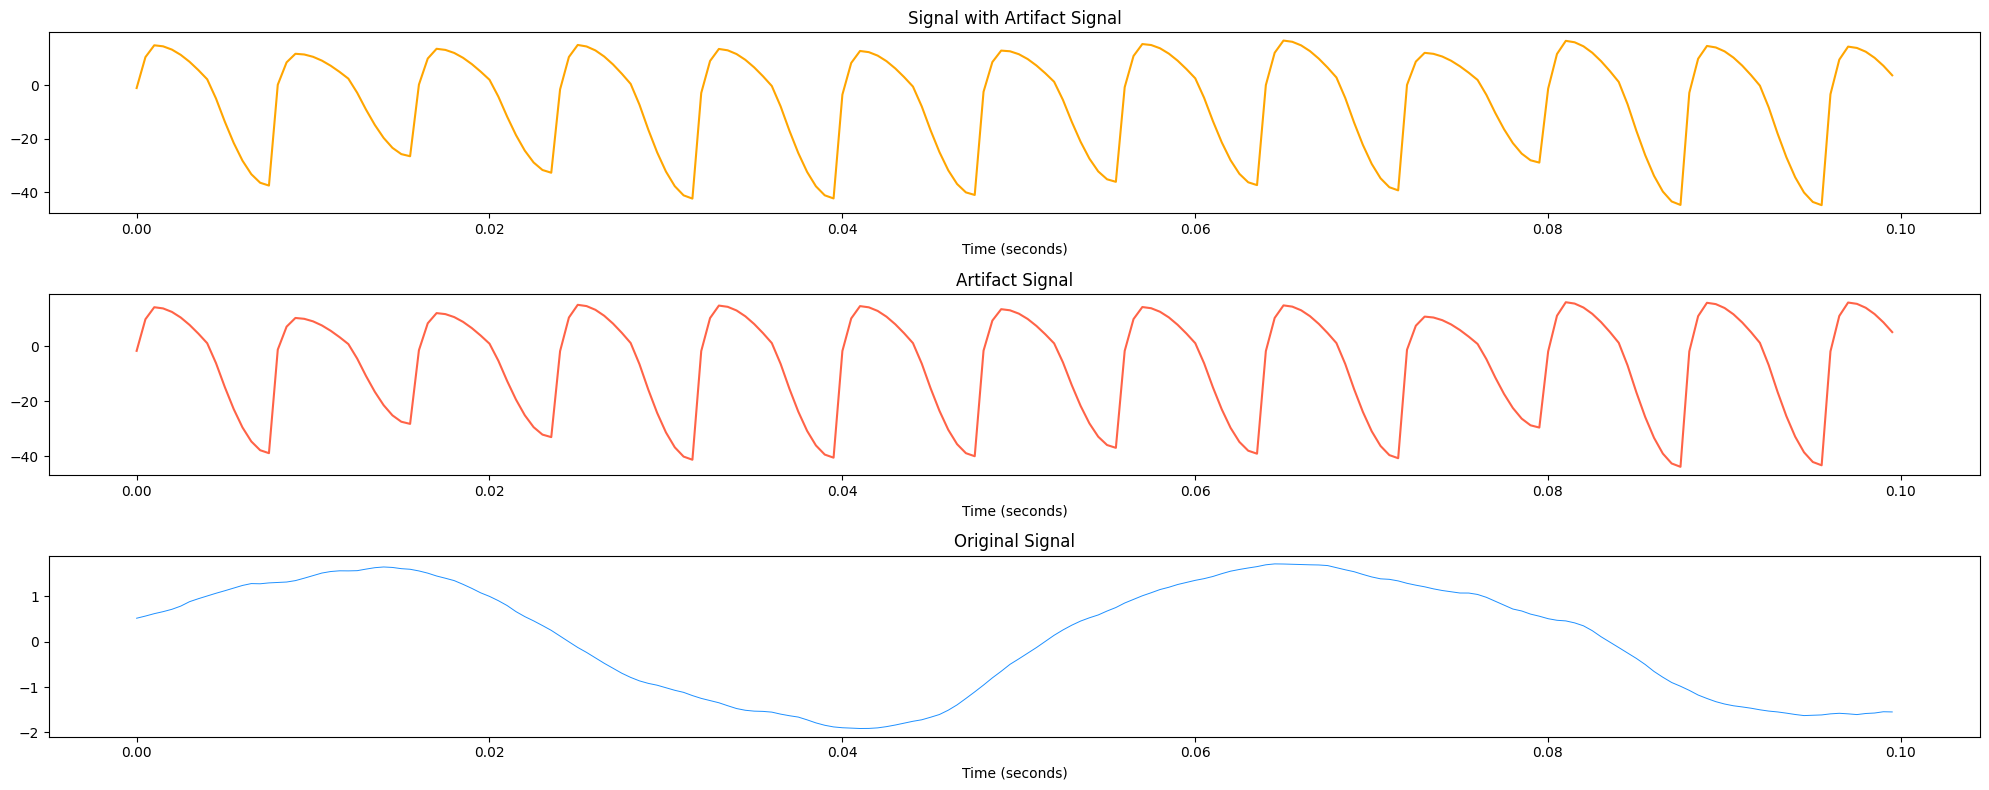

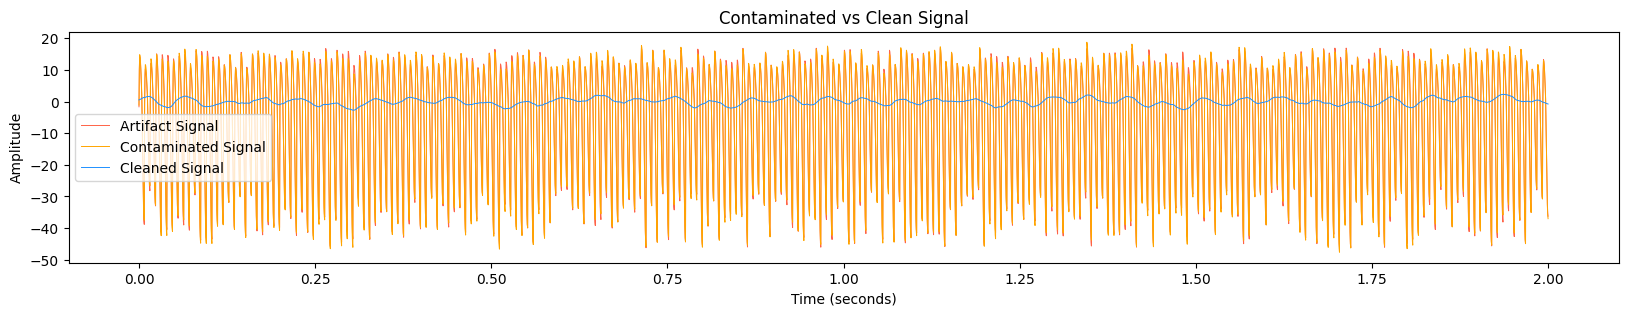

In [9]:
t = np.linspace(0, 2, num=4000) 

plt.figure(figsize=(20,8))
plt.subplot(3, 1, 1)
plt.plot(t[:200], sig_with_artifact[0][:200], color='orange');plt.xlabel("Time (seconds)");plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(t[:200], artifact[0][:200], color='tomato');plt.xlabel("Time (seconds)");plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(t[:200], sig[0][:200], color='dodgerblue', linewidth = 0.7);plt.xlabel("Time (seconds)");plt.title('Original Signal')
# plt.xlim(0.0270, 0.0280)
# plt.ylim(-0.75, -0.65)

plt.tight_layout()

plt.figure(figsize=(20, 3))
plt.plot(t, artifact[0], label='Artifact Signal', color='tomato', alpha=1, linewidth=0.7)
plt.plot(t, sig_with_artifact[0], label='Contaminated Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(t, sig[0], label='Cleaned Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)');plt.ylabel('Amplitude');plt.title('Contaminated vs Clean Signal');plt.legend();plt.show()

In [10]:
# z-score normalization
scaler = StandardScaler()

sig_with_artifact = scaler.fit_transform(sig_with_artifact.T)
sig = (sig.T-scaler.mean_)/np.sqrt(scaler.var_) # X와 동일한 평균, 표준 편차로 scaling

sig_with_artifact = sig_with_artifact.T; sig = sig.T

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


(1000, 2001)
(1000, 2001)
(2001,)
(1000, 2001)
(1000, 2001)
(2001,)


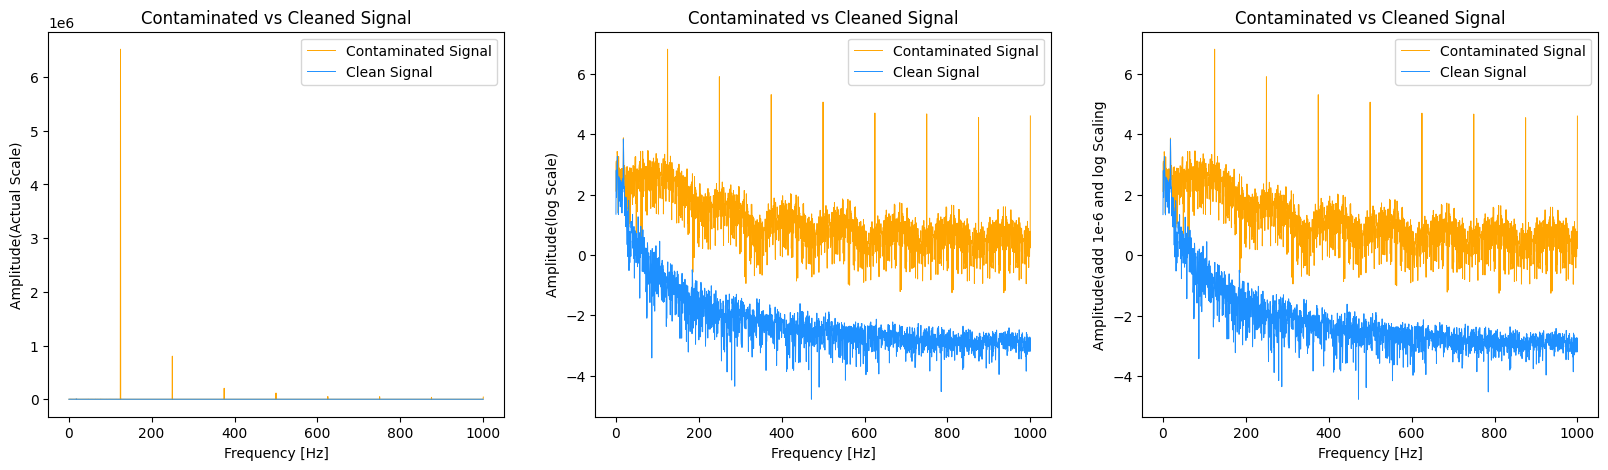

In [26]:
# power spectrum으로 변환
n = len(sig_with_artifact[0])

fs = 2000
freqs = np.fft.rfftfreq(n, d=1/fs)

fft_contaminated = np.fft.rfft(sig_with_artifact, axis=1)
power_contaminated = np.abs(fft_contaminated)**2

fft_clean = np.fft.rfft(sig, axis=1)
power_clean = np.abs(fft_clean)**2

print(power_contaminated.shape)
print(power_clean.shape)
print(freqs.shape)

plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.plot(freqs[1:], power_contaminated[0][1:], label='Contaminated Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(freqs[1:], power_clean[0][1:], label='Clean Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Frequency [Hz]');plt.ylabel('Amplitude(Actual Scale)');plt.title('Contaminated vs Cleaned Signal');plt.legend()

plt.subplot(1,3,2)
plt.plot(freqs[1:], np.log10(power_contaminated[0][1:]), label='Contaminated Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(freqs[1:], np.log10(power_clean[0][1:]), label='Clean Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Frequency [Hz]');plt.ylabel('Amplitude(log Scale)');plt.title('Contaminated vs Cleaned Signal');plt.legend()

# Data preprocessing
X = np.log10(power_contaminated + 1e-6)
y = np.log10(power_clean + 1e-6)

print(X.shape)
print(y.shape)
print(freqs.shape)

plt.subplot(1,3,3)
plt.plot(freqs[1:], X[0][1:], label='Contaminated Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(freqs[1:], y[0][1:], label='Clean Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Frequency [Hz]');plt.ylabel('Amplitude(add 1e-6 and log Scaling');plt.title('Contaminated vs Cleaned Signal');plt.legend();plt.show()




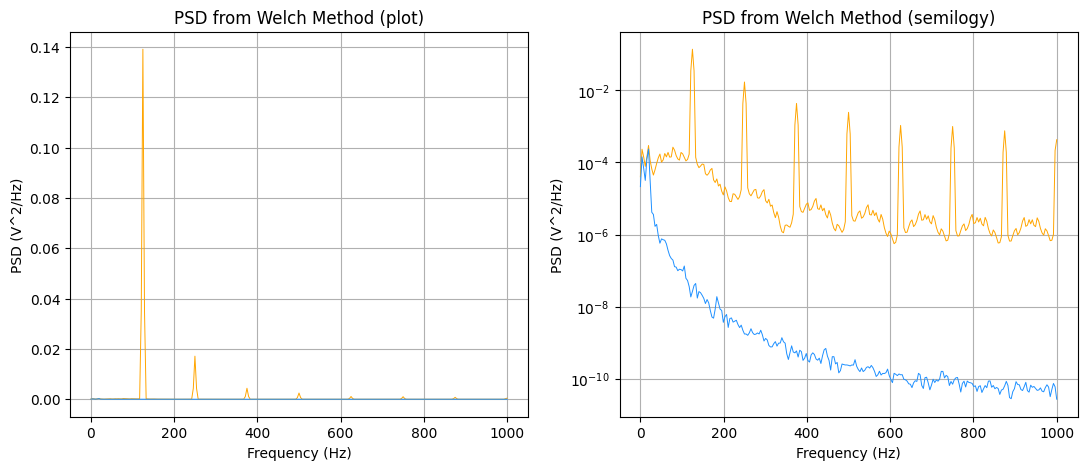

freqs.shape: (257,)
Contaminated PSD.shape: (1000, 257)
Clean_PSD.shape: (1000, 257)


In [33]:
# Welch's method 매개변수
nperseg = 512  # 각 세그먼트의 길이

# 각 시계열 데이터에 대해 Welch's method 적용하여 주파수 및 PSD 계산
Contaminated_results = [welch(sig_with_artifact[i], fs, nperseg=nperseg) for i in range(len(sig_with_artifact))]
Clean_results = [welch(sig[i], fs, nperseg=nperseg) for i in range(len(sig))]

# 결과를 주파수와 PSD 리스트로 분리
Contaminated_frequencies_list, Contaminated_psd_list = zip(*Contaminated_results)
Clean_frequencies_list, Clean_psd_list = zip(*Clean_results)

# 첫 번째 시계열 데이터의 PSD 결과를 플로팅 
plt.figure(figsize=(13, 5)) 
plt.subplot(1,2,1)
plt.plot(Contaminated_frequencies_list[0], Contaminated_psd_list[0], color='orange', alpha=1, linewidth=0.7)
plt.plot(Clean_frequencies_list[0], Clean_psd_list[0], color='dodgerblue', alpha=1, linewidth=0.7)
plt.title('PSD from Welch Method (plot)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.grid()

plt.subplot(1,2,2)
plt.semilogy(Contaminated_frequencies_list[0], Contaminated_psd_list[0], color='orange', alpha=1, linewidth=0.7)
plt.semilogy(Clean_frequencies_list[0], Clean_psd_list[0], color='dodgerblue', alpha=1, linewidth=0.7)
plt.title('PSD from Welch Method (semilogy)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.grid()
plt.show()

# 주파수와 PSD 결과를 배열로 변환
freqs = np.array(Contaminated_frequencies_list[0])
Contaminated_psd_array = np.array(Contaminated_psd_list)
Clean_psd_array = np.array(Clean_psd_list)

print(f"freqs.shape: {freqs.shape}") # (257,)
print(f"Contaminated PSD.shape: {Contaminated_psd_array.shape}") # (1000, 257)
print(f"Clean_PSD.shape: {Clean_psd_array.shape}") # (1000, 257)

# X = np.log10(Contaminated_psd_array)
# y = np.log10(Clean_psd_array)
X = Contaminated_psd_array
y = Clean_psd_array